# Second Scenario - Scaling

In [6]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Objectives
The last prototype demonstrated good performance on smaller problems, but its performance was shown to quickly degrade on larger ones. This scenario intends to address this problem. 

# State
Agents know:

- The positions of the closest _i_ agents
- The positions of the closest _j_ sensors that have not been visited yet
- Their own position

Now that only _i_ agents and _j_ sensors are visible, the state space no longer linearly scales with the number of drones or sensors, it is constant. Also, since only non-visited sensors are in the state, agents no longer need to know which sensors have been visited.

# Reward
- Number of sensors visited for the first time in the last iteration
- -1 to an agent that leaves the scenario's area

This new reward intends to address the sparsity of the previous one. Rewards are more frequent, every time a sensor is visited for the first time instead of once in the end of the episode. It's also more forgiving, as agents are rewarded even if not all sensors are visited by the end of the scenario. This change intends to accelerate learning.

# Training
While a policy is being learned during training, it is important that a diverse set of experiences are collected, containing both successes and failures. A high quantity of experiences is not enough, they also have to be meaningful. In the previous scenario, if the agents could not visit all sensors and did not leave the simulation area, the episode would end at a parametrized time limit. Since the behavior of not leaving the scenario's area is pretty quickly learned, but the data collection behavior is not, simulations would run until the time limit very frequently. This means that a lot of meaningless data of the agents wondering around in the scenario until the time limit were being collected.

To help with this, this termination condition was changed. Instead of terminating the simulation at a parametrized time limit, a stall counter would be implemented. It resets to zero every time a new sensor is visited and counts the number of seconds since a new sensor was last visited. A new parameter was introduced to specify the maximum number of seconds stalled, having been reached the episode is terminated. Using this new strategy, simulations where meaningful data is being collected (sensors are being visited) are allowed to continue, whereas simulations where the agents are "confused" can be terminated early. This stall limit can be set much lower than the time limit.

# Algorithm
The DDPG algorithm makes a training iteration every episode iteration. Since we are using multiple agents, multiple experiences are collected at every iteration. Before we were training once every episode iteration, but we should really be training once for every experience collected, to match the experience x training ratio of the regular DDPG algorithm.

# Sensor number evaluation
To evaluate how these changes have affected results, we will run a campaign evaluating the performance on 

## Parameters
- Number of drones = 1
- Number of sensors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
- Scenario square size = 100
- Training time = 10mil

## Results

In [7]:
%tensorboard --logdir runs/sensors

Reusing TensorBoard on port 6009 (pid 102314), started 1:06:44 ago. (Use '!kill 102314' to kill it.)

## Conclusion
The optimizations have had an immense impact on performance. All scenarios, even the hardest ones, optimized successfully to some level. The individual impact of each optimization still hast to be measured.

The policy converged to a suboptimal solution in some scenarios. Still magnitudes better than previous results, but not quite optimal. Further analysis is required.

# Ablation testing
We'll be removing individual optimizations to study their impact on performance. Measurements from this experiment evaluates if each of the optimizations implemented in this scenario had an actual impact on results.

## Parameters
The parameters being varied are:
- State: [before optimization (agents know the positions of all agents and sensors), after optimization (agents know the position of the two closest agents (control)]
- Reward: [old sparse reward, new dense reward (control)]
- Episode length: [old max simulation duration, new max stall duration (control)]
- Out of bounds treatment: [punish agents, block agents (control)]
- Algorithm training: [train once, train once per agent (control)]

In [8]:
%tensorboard --logdir runs/ablation

## Conclusions
Most changes actually made a difference when compared to the control run. The only optimization that didn't seem to effect the results positively was the blockage of out of bounds actions, instead of punishing them. 

# State optimization
One possible cause for the suboptimal results obtained in the first campaign in this scenario is the state. It's possible that it is not representing the environment in a way that facilitates learning. Several new states will be developed.

## Parameters
- States:
    - all_positions: Every agent knows the position of all sensors and agents
    - absolute: An agent knows the absolute position of himself, the closest _i_ agents and _j_ sensors.
    - relative: An agent knows the relative position of the closest _i_ agents and _j_ sensors.
    - distance_angle: An agent knows the distance and angle to the closest _i_ agents and _j_ sensors.
    - angle: An agent knows the angle to the closest _i_ agents and _j_ sensors.

## Results

In [9]:
%tensorboard --logdir runs/states

Reusing TensorBoard on port 6008 (pid 102040), started 1:07:17 ago. (Use '!kill 102040' to kill it.)

## Conclusions
The state utilizing relative positions was the most optimal one. This indicates that state size is not all that matters, since the "angle" state was actually the smallest. It would be beneficial to analyze how the number of closest sensors and agents present in the relative state effect performance.

# Multiagent Performance
We've been running our last campaigns using a single agent. It's time to measure the performance with multiple agents.

## Parameters
- Number of drones = [2,3,4]
- Number of sensors = [2, 4, 8]

## Results

In [10]:
%tensorboard --logdir runs/multiagent

Reusing TensorBoard on port 6007 (pid 32387), started 5:42:22 ago. (Use '!kill 32387' to kill it.)

# Conclusions
Performance was adequate in all runs. Comparing the 4 sensor runs, an interesting pattern emerges. The 4-drone version was actually the more performant. Complexity usually increases with the number of drones, so this was surprising.

# Are drones collaborating?
The past results that didn't show a decrease in performance with the increase in the number of drones indicate that more drones does not actually mean more complexity. This would be true if the drones weren't actually collaborating. In that case, four drones would only mean more experience for the trained model, and no collaborative behavior surfaces. This scenario evaluates if this hypothesis is true.

## Parameters

All experiments were run using the "relative positions" state. This state presents the agents with the relative positions of the _i_ closest agents and _j_ closest sensors. Runs will limit the number of agents and sensors each agent has information about. By observing how that affects performance, we may be able to tell if states that favor collaboration (agents know information about more sensors and agents).
- Closest agents (_i_) = [0, 1, 3]
- Closest sensors (_j_) = [1, 2, 4]

## Results

In [11]:
%tensorboard --logdir runs/closest

Reusing TensorBoard on port 6010 (pid 116417), started 0:43:46 ago. (Use '!kill 116417' to kill it.)

## Conclusions
The number of agents and sensors in the scenario are fixed. The only thing that varies is the amount of information fed to them. It seems that, even though the scenario has 4 agents, the runs that present agents with the simplest possible state are the ones that are more optimal. The most optimal one only presents agents with the information about 1 sensor and 0 other agents. No collaboration is possible under these conditions, and yet it's the most performant.

A visual evaluation of how the agents are acting in the most optimal scenario show this:
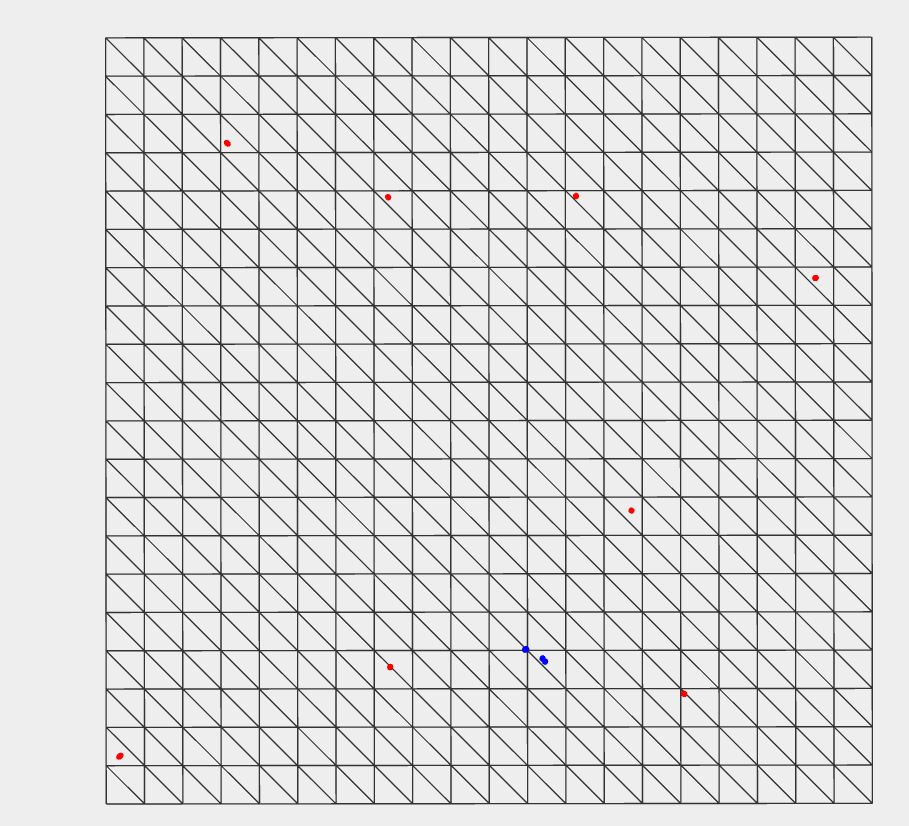

Agents are traveling together, no collaborating and just acting as a single agent. I believe that this scenario doesn't foster collaboration because it is too easily solved individually